In [1]:
import sys
import os
import re

import cProfile
import pstats
import io
from memory_profiler import profile

import scipy
from scipy.stats import gaussian_kde

import pandas as pd
from anndata import read_h5ad
import mellon
import palantir
import scanpy as sc

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from tqdm.contrib.itertools import product

In [2]:
import jax.numpy as jnp

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import plotnine as p9

In [4]:
import matplotlib

%matplotlib inline
matplotlib.rcParams["figure.dpi"] = 72  # 150 dpi resolution
matplotlib.rcParams["image.cmap"] = "RdBu_r"  # preferred color map
matplotlib.rcParams["figure.figsize"] = [12, 12]  # Square
# no bounding boxes or axis:
matplotlib.rcParams["axes.spines.bottom"] = "off"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "off"
matplotlib.rcParams["axes.spines.right"] = "off"
# use Arial
matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["font.family"] = "sans-serif"
p9.options.figure_size = (15, 5)

In [5]:
ds_names = ["tcell", "ips", "covid", "cd34", "mgast"]
ad_base_dir = "/fh/fast/setty_m/user/dotto/CellDensities/data/subsamples/hierarchical"
bench_base_dir = "/fh/fast/setty_m/user/dotto/CellDensities/data/benchmarks/subsamples"

run_modes = {
    "hierarchical": ("hierarchical", 36, True, "n_obs", None, "log"),
    "hierarchical_noNy": ("hierarchical", 36, False, "n_obs", None, "log"),
    "stability_ls": ("none", 36, True, "length_scale_fac", 1.0, "log"),
    "stability_ls_noNy": ("none", 36, False, "length_scale_fac", 1.0, "log"),
    "stability_d_noNy": ("none", 36, False, "d", "lookup:n_dims", "llinear"),
    "stability_n_landmarks": ("none", 36, True, "n_landmarks", 5000, "log"),
    "stability_n_landmarks_noNy": ("none", 36, False, "n_landmarks", 5000, "log"),
    "stability_rank": ("none", 36, True, "target_rank", 0.99, "log"),
    "stability_dmc_noNy": ("hierarchical", 36, False, "dm_comps", None, "linear"),
    "hierarchical_1core": ("hierarchical", 1, True, "n_obs", None, "log"),
    "hierarchical_noNy_1core": ("hierarchical", 1, False, "n_obs", None, "log"),
    "hierarchical_noNy_fractal_k30n1000": (
        "hierarchical",
        36,
        False,
        "n_obs",
        None,
        "log",
    ),
}
run_modes_desc = (
    "subsampling",
    "cores",
    "nystrom",
    "variing",
    "default_value",
    "scale",
)
aliases = {
    "n_obs": "# of cells",
    "length_scale_fac": "length scale factor",
    "n_landmarks": "# of landmarks",
    "target_rank": "Nyström retained variance",
    "dm_comps": "# of diffusion components",
}

In [6]:
pattern = re.compile("log_densities_([0-9]*).csv")
other_lines = list()
densities_lines = list()
run_modes_s = {
    mode: pd.DataFrame(
        dict(zip(run_modes_desc, desc)),
        index=[
            0,
        ],
    )
    for mode, desc in run_modes.items()
}


def numerify(col):
    try:
        return pd.to_numeric(col)
    except (ValueError, TypeError):
        return col


results_dict = dict()
stats_dict = dict()
for ds_name, (mode, b_stats) in product(ds_names, run_modes_s.items()):
    density_list = list()
    ds_lines = list()
    result_dir = f"{bench_base_dir}/{mode}/{ds_name}/"
    fl_list = os.listdir(result_dir)

    for fl in tqdm(
        sorted(fl_list), total=len(fl_list), desc=f"{ds_name} {mode}", leave=False
    ):
        if not (match := pattern.match(fl)):
            continue
        idstr = match.groups()[0]
        try:
            densities = pd.read_csv(
                f"{bench_base_dir}/{mode}/{ds_name}/log_densities_{idstr}.csv",
                index_col=0,
            )
        except FileNotFoundError:
            print(
                f"Not found: {ds_name} - {mode} - {idstr} in {bench_base_dir}/{mode}/{ds_name}/"
            )
            continue

        densities.columns = [
            idstr,
        ]
        density_list.append(densities)

        a_stats = pd.DataFrame(
            {"id_str": idstr, "dataset": ds_name, "mode": mode},
            index=[
                0,
            ],
        )
        c_stats = pd.read_csv(
            f"{bench_base_dir}/{mode}/{ds_name}/estimator_stats_{idstr}.csv",
            index_col=0,
        ).T.reset_index()
        if "n_obs" not in c_stats.columns:
            c_stats["n_obs"] = densities.shape[0]
        dv = b_stats["default_value"].values[0]
        if dv is not None and isinstance(dv, str) and dv.startswith("lookup:"):
            _, what = dv.split(":")
            b_stats["default_value"] = c_stats[what].values
        ds_lines.append(pd.concat([a_stats, b_stats, c_stats], axis=1))

    key = f"{ds_name} {mode}"
    results_dict[key] = pd.concat(density_list, axis=1)
    stats_dict[key] = (
        pd.concat(ds_lines, axis=0).set_index("id_str").apply(numerify, axis=0)
    )

  0%|          | 0/60 [00:00<?, ?it/s]

tcell hierarchical:   0%|          | 0/210 [00:00<?, ?it/s]

tcell hierarchical_noNy:   0%|          | 0/210 [00:00<?, ?it/s]

tcell stability_ls:   0%|          | 0/402 [00:00<?, ?it/s]

tcell stability_ls_noNy:   0%|          | 0/402 [00:00<?, ?it/s]

tcell stability_d_noNy:   0%|          | 0/303 [00:00<?, ?it/s]

tcell stability_n_landmarks:   0%|          | 0/388 [00:00<?, ?it/s]

tcell stability_n_landmarks_noNy:   0%|          | 0/388 [00:00<?, ?it/s]

tcell stability_rank:   0%|          | 0/402 [00:00<?, ?it/s]

tcell stability_dmc_noNy:   0%|          | 0/300 [00:00<?, ?it/s]

tcell hierarchical_1core:   0%|          | 0/210 [00:00<?, ?it/s]

tcell hierarchical_noNy_1core:   0%|          | 0/210 [00:00<?, ?it/s]

tcell hierarchical_noNy_fractal_k30n1000:   0%|          | 0/210 [00:00<?, ?it/s]

ips hierarchical:   0%|          | 0/370 [00:00<?, ?it/s]

ips hierarchical_noNy:   0%|          | 0/370 [00:00<?, ?it/s]

ips stability_ls:   0%|          | 0/402 [00:00<?, ?it/s]

ips stability_ls_noNy:   0%|          | 0/402 [00:00<?, ?it/s]

ips stability_d_noNy:   0%|          | 0/303 [00:00<?, ?it/s]

ips stability_n_landmarks:   0%|          | 0/206 [00:00<?, ?it/s]

ips stability_n_landmarks_noNy:   0%|          | 0/212 [00:00<?, ?it/s]

ips stability_rank:   0%|          | 0/402 [00:00<?, ?it/s]

ips stability_dmc_noNy:   0%|          | 0/300 [00:00<?, ?it/s]

ips hierarchical_1core:   0%|          | 0/370 [00:00<?, ?it/s]

ips hierarchical_noNy_1core:   0%|          | 0/370 [00:00<?, ?it/s]

ips hierarchical_noNy_fractal_k30n1000:   0%|          | 0/370 [00:00<?, ?it/s]

covid hierarchical:   0%|          | 0/325 [00:00<?, ?it/s]

covid hierarchical_noNy:   0%|          | 0/325 [00:00<?, ?it/s]

covid stability_ls:   0%|          | 0/402 [00:00<?, ?it/s]

covid stability_ls_noNy:   0%|          | 0/402 [00:00<?, ?it/s]

covid stability_d_noNy:   0%|          | 0/303 [00:00<?, ?it/s]

covid stability_n_landmarks:   0%|          | 0/206 [00:00<?, ?it/s]

covid stability_n_landmarks_noNy:   0%|          | 0/350 [00:00<?, ?it/s]

covid stability_rank:   0%|          | 0/402 [00:00<?, ?it/s]

covid stability_dmc_noNy:   0%|          | 0/300 [00:00<?, ?it/s]

covid hierarchical_1core:   0%|          | 0/325 [00:00<?, ?it/s]

covid hierarchical_noNy_1core:   0%|          | 0/325 [00:00<?, ?it/s]

covid hierarchical_noNy_fractal_k30n1000:   0%|          | 0/325 [00:00<?, ?it/s]

cd34 hierarchical:   0%|          | 0/200 [00:00<?, ?it/s]

cd34 hierarchical_noNy:   0%|          | 0/200 [00:00<?, ?it/s]

cd34 stability_ls:   0%|          | 0/402 [00:00<?, ?it/s]

cd34 stability_ls_noNy:   0%|          | 0/402 [00:00<?, ?it/s]

cd34 stability_d_noNy:   0%|          | 0/303 [00:00<?, ?it/s]

cd34 stability_n_landmarks:   0%|          | 0/388 [00:00<?, ?it/s]

cd34 stability_n_landmarks_noNy:   0%|          | 0/388 [00:00<?, ?it/s]

cd34 stability_rank:   0%|          | 0/402 [00:00<?, ?it/s]

cd34 stability_dmc_noNy:   0%|          | 0/300 [00:00<?, ?it/s]

cd34 hierarchical_1core:   0%|          | 0/200 [00:00<?, ?it/s]

cd34 hierarchical_noNy_1core:   0%|          | 0/200 [00:00<?, ?it/s]

cd34 hierarchical_noNy_fractal_k30n1000:   0%|          | 0/200 [00:00<?, ?it/s]

mgast hierarchical:   0%|          | 0/300 [00:00<?, ?it/s]

mgast hierarchical_noNy:   0%|          | 0/300 [00:00<?, ?it/s]

mgast stability_ls:   0%|          | 0/402 [00:00<?, ?it/s]

mgast stability_ls_noNy:   0%|          | 0/402 [00:00<?, ?it/s]

mgast stability_d_noNy:   0%|          | 0/303 [00:00<?, ?it/s]

mgast stability_n_landmarks:   0%|          | 0/206 [00:00<?, ?it/s]

mgast stability_n_landmarks_noNy:   0%|          | 0/388 [00:00<?, ?it/s]

mgast stability_rank:   0%|          | 0/402 [00:00<?, ?it/s]

mgast stability_dmc_noNy:   0%|          | 0/300 [00:00<?, ?it/s]

mgast hierarchical_1core:   0%|          | 0/300 [00:00<?, ?it/s]

mgast hierarchical_noNy_1core:   0%|          | 0/300 [00:00<?, ?it/s]

mgast hierarchical_noNy_fractal_k30n1000:   0%|          | 0/300 [00:00<?, ?it/s]

In [7]:
corr_dict = {k: df.corr(method="spearman") for k, df in tqdm(results_dict.items())}

  0%|          | 0/60 [00:00<?, ?it/s]

In [8]:
def plot_correlations(
    statistic_df,
    nticks=0,
    fig=None,
    clim=(-1, 1),
    stat_name="Spearman correlation",
    cmap="RdBu_r",
    lims=(None, None),
):
    if fig is None:
        fs = matplotlib.rcParams["figure.figsize"]
        fig = plt.figure(figsize=[fs[0], fs[1] * 1.5])
    stats = stats_dict[key]
    variable = stats["variing"][0]
    scale = stats["scale"][0]
    default = stats["default_value"][0]
    sstats = stats.sort_values(variable)
    if variable == "n_landmarks":
        sstats = sstats.loc[sstats[variable] > 0, :]
    if lims is not None:
        if lims[0] is not None:
            sstats = sstats.loc[sstats[variable] > lims[0], :]
        if lims[1] is not None:
            sstats = sstats.loc[sstats[variable] < lims[1], :]
    sstats = sstats.drop_duplicates(subset=[variable])
    matrix = statistic_df.loc[sstats.index, sstats.index]

    mask = ~matrix.isna().all(axis=0).values
    matrix = matrix.loc[mask, mask]
    sstats = sstats.loc[mask, :]

    size = matrix.shape[0]
    ticks = np.linspace(0, size - 1, nticks).astype(int)
    labels = sstats[variable].values[ticks]
    try:
        labels = [f"{l:.2}" for l in labels]
    except ValueError:
        # the lables are probably integers
        labels = [f"{l:,}" for l in labels]

    color_bar_heigh = 0.3
    color_bar_base = 0.05
    if default is not None and not np.isnan(default):
        try:
            default_tick = sstats[variable].searchsorted(default)
        except TypeError:
            print(default)
            print(variable)
            raise
        ticks = np.append(ticks, default_tick)
        try:
            labels.append(f"default: {default:.3}")
        except ValueError:
            labels.append(f"default: {default:,}")
        tick_order = np.argsort(ticks)
        ticks = ticks[tick_order]
        labels = np.array(labels)[tick_order]

        tick_height = min(ticks) / size
        color_bar_heigh = min(tick_height - 0.1, color_bar_heigh)
    if color_bar_heigh < 0.1:
        color_bar_base += color_bar_heigh + 0.1
        color_bar_heigh = 0.3

    ax, axr = fig.subplots(
        2, 1, height_ratios=[2, 1], sharex=True, gridspec_kw={"hspace": 1e-2}
    )
    img = ax.pcolormesh(matrix, cmap=cmap)
    if clim is not None:
        img.set_clim(*clim)
    # cb = plt.colorbar(img, ax=[ax],location='left')
    if nticks > 0:
        cbar_x = -0.15
    else:
        cbar_x = -0.12
    cax = ax.inset_axes([cbar_x, color_bar_base, 0.03, color_bar_heigh])
    cb = fig.colorbar(img, ax=ax, cax=cax)
    # cax.yaxis.tick_left()
    cax.yaxis.set_label_position("left")
    cax.set_ylabel(stat_name, rotation=90)
    ax.set_xticks(ticks + 0.5, labels, rotation=90, weight="bold")
    ax.set_yticks(ticks + 0.5, labels, weight="bold")
    # ax.yaxis.tick_right()
    ax.set_title(key + "\n")

    axr.plot(np.arange(matrix.shape[0]) + 0.5, sstats[variable])
    # axr.scatter(sstats[variable], range(matrix.shape[0]))
    ylab = aliases.get(variable, variable)
    axr.set_ylabel(ylab)
    axr.set_xticks(ticks + 0.5, labels, weight="bold")
    if default is not None and not np.isnan(default):
        ax.hlines(default_tick + 0.5, 0, size, colors="k", alpha=0.3)
        ax.vlines(default_tick + 0.5, 0, size, colors="k", alpha=0.3)
        axr.vlines(
            default_tick + 0.5, 0, np.max(sstats[variable]), colors="red", linewidth=1
        )
    if nticks > 0:
        axr.set_xlabel(ylab)
    else:
        axr.set_xlabel("benchmark runs")
    axr.grid(which="both", axis="both")
    if scale == "log":
        axr.semilogy()
        axr.yaxis.set_minor_locator(LogLocator(subs=range(10), numticks=100))

# Subsampling

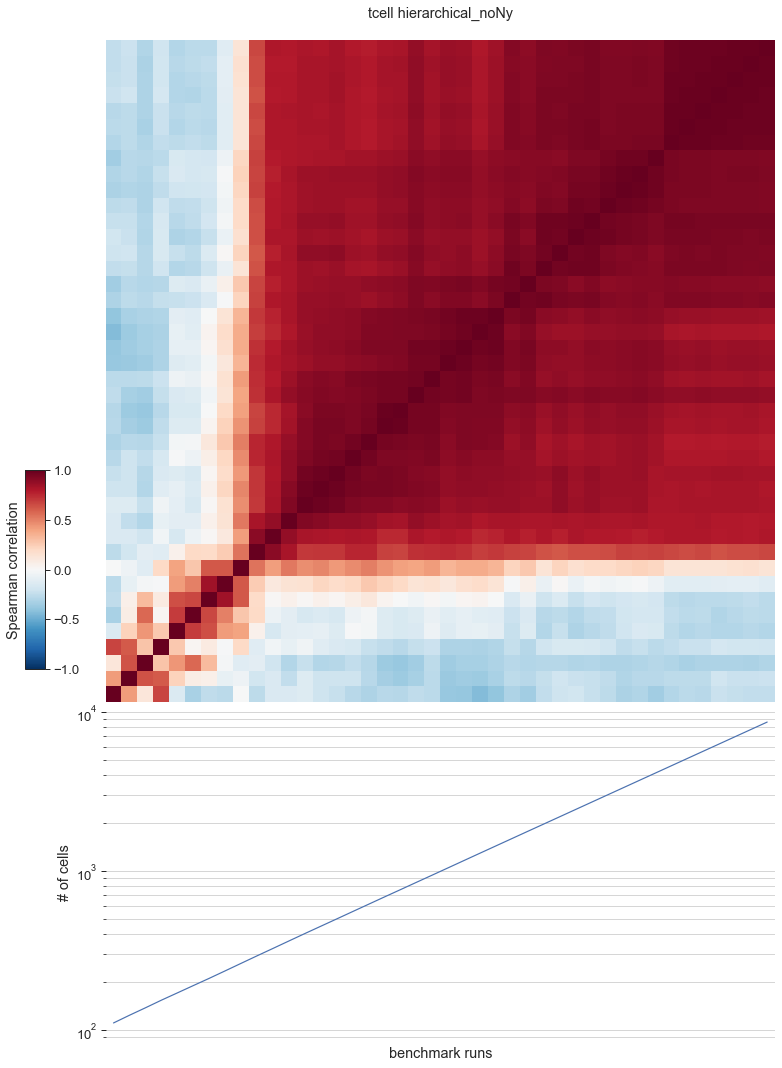

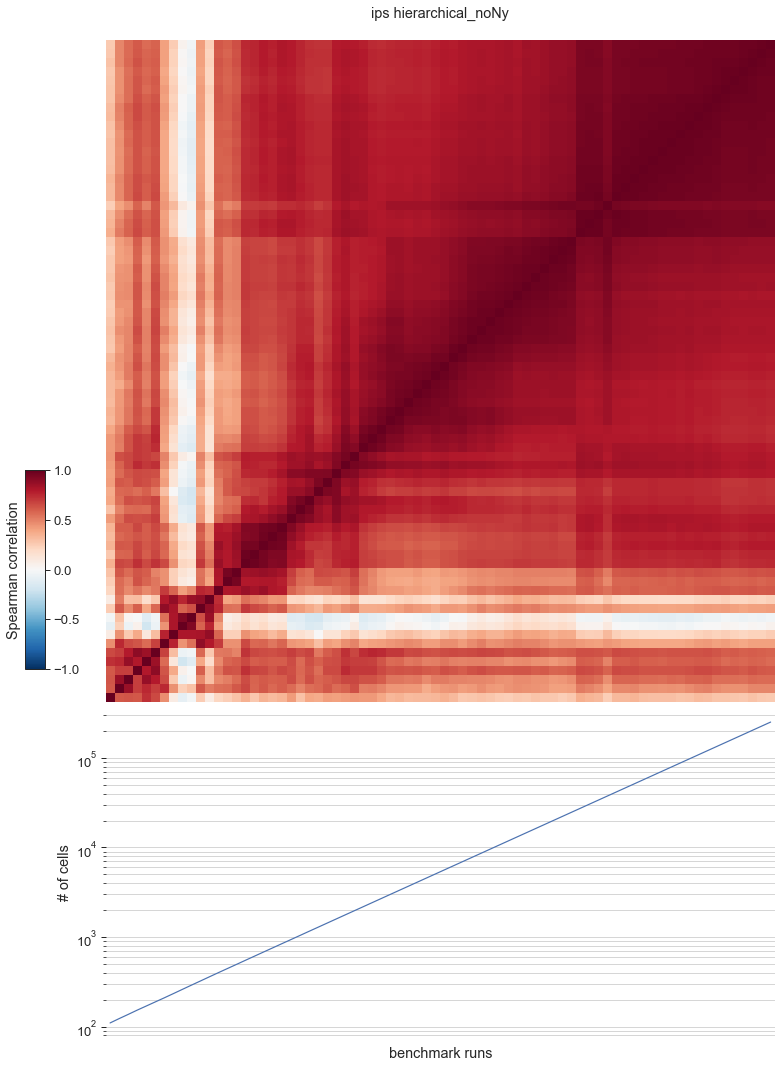

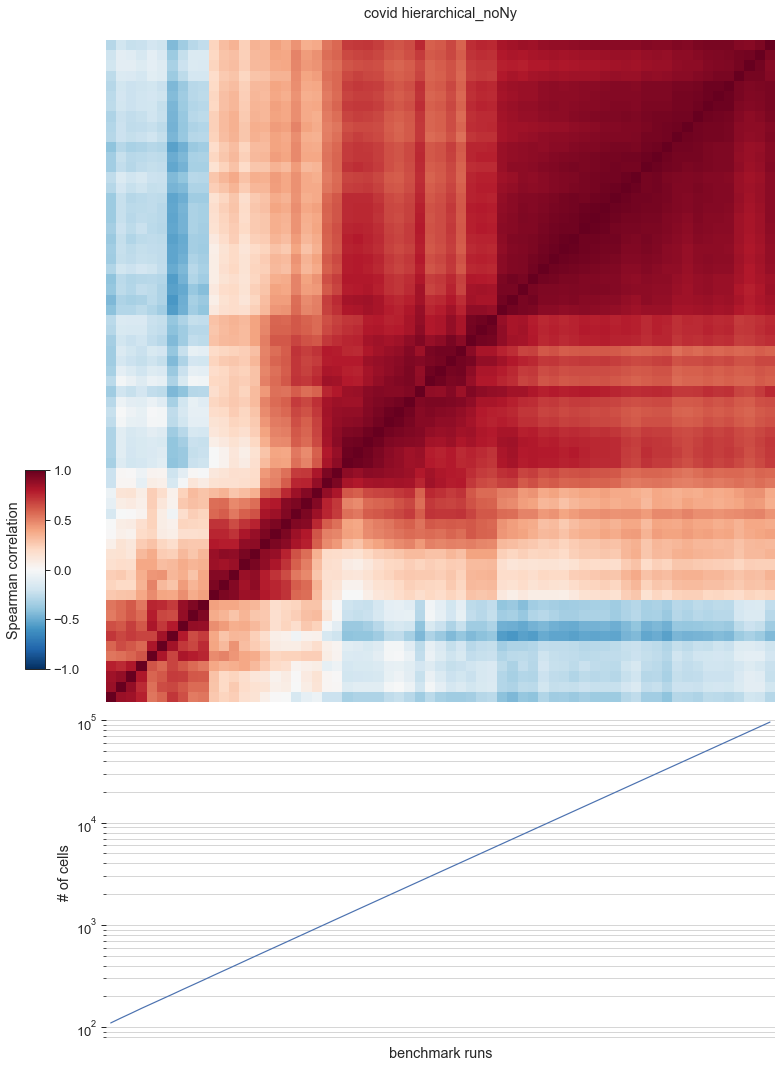

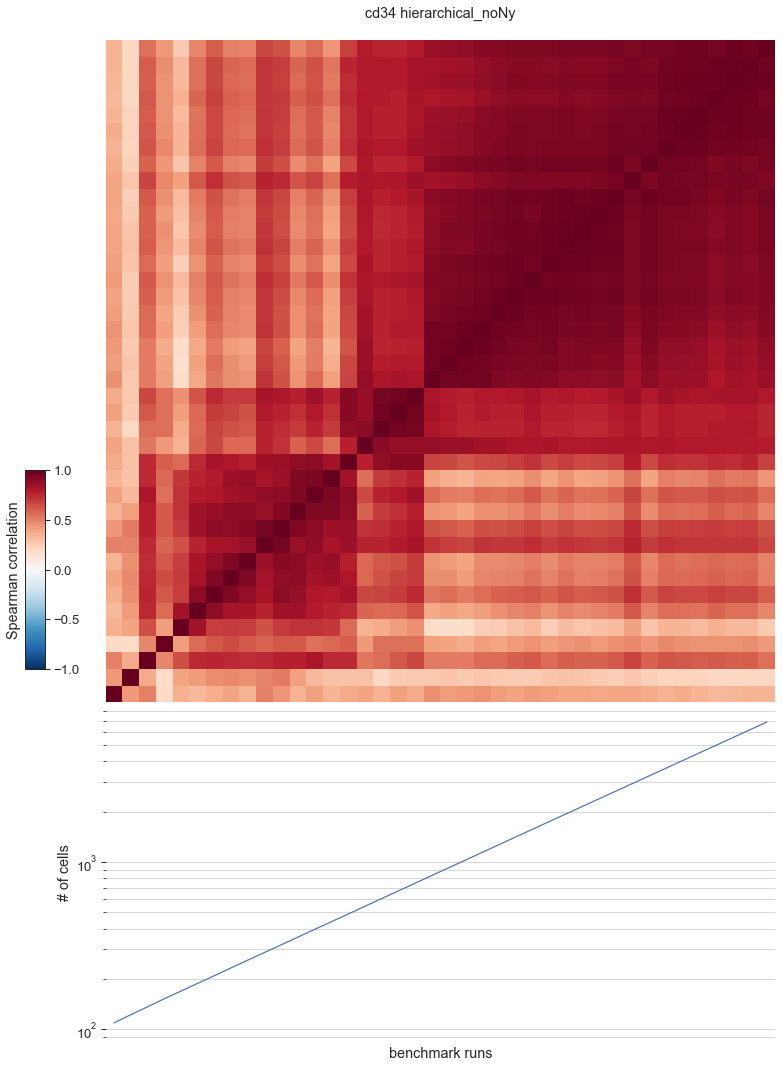

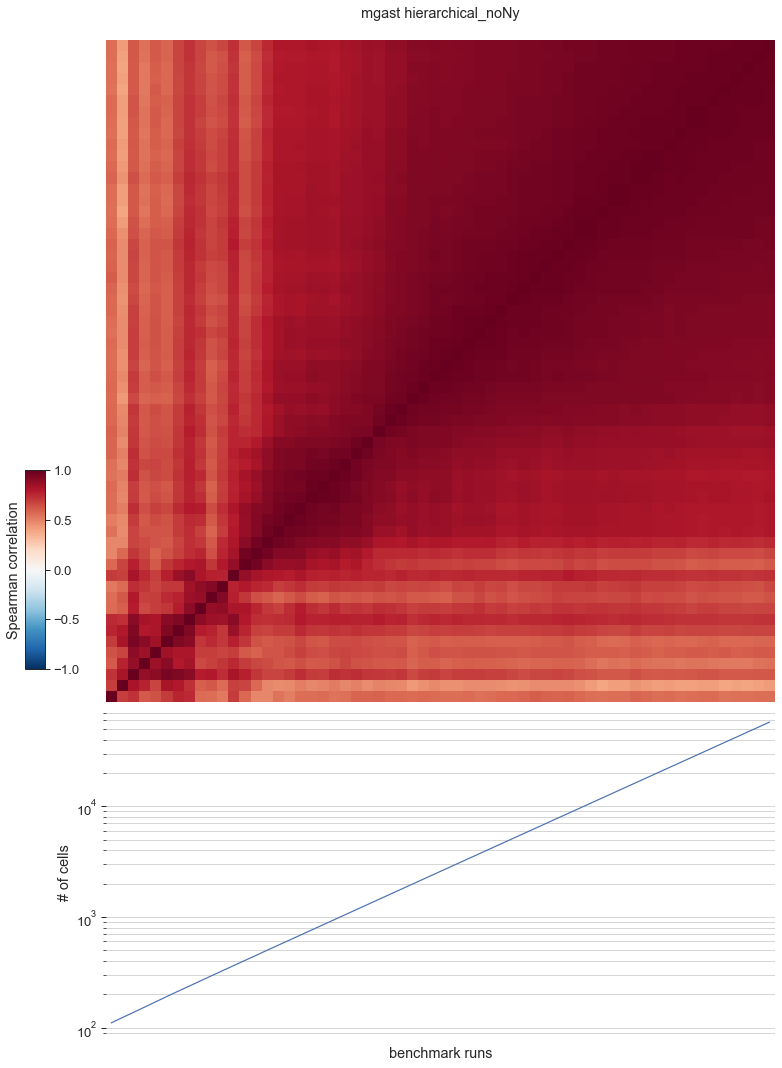

In [9]:
for key, cdf in corr_dict.items():
    if not key.endswith("hierarchical_noNy"):
        continue
    plot_correlations(corr_dict[key], nticks=0)
    plt.show()

# Subsampling Low Density

In [10]:
from scipy.stats import spearmanr

quantile_threshold = 0.1


def low_dens_corr(x, y):
    s = x + y
    idx = s < np.quantile(s, quantile_threshold)
    return spearmanr(x[idx], y[idx]).correlation


ldcprr_dict = {k: df.corr(method=low_dens_corr) for k, df in tqdm(results_dict.items())}

  0%|          | 0/60 [00:00<?, ?it/s]

/fh/fast/setty_m/user/dotto/mamba/envs/cestiny-16/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


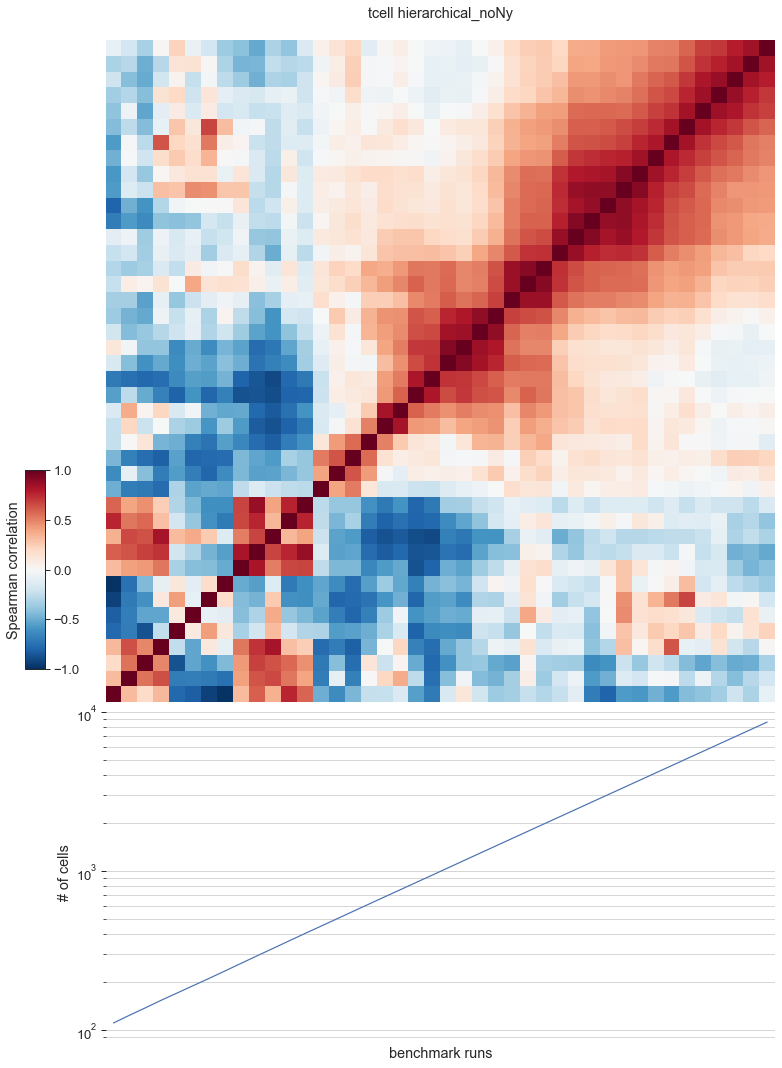

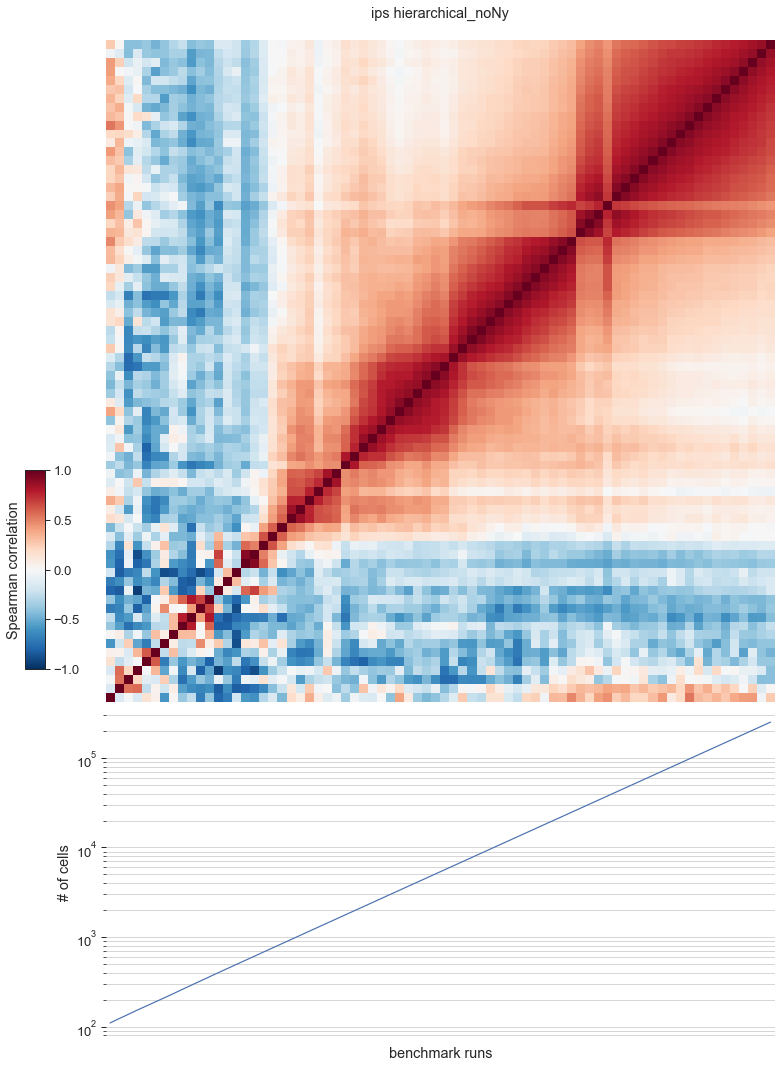

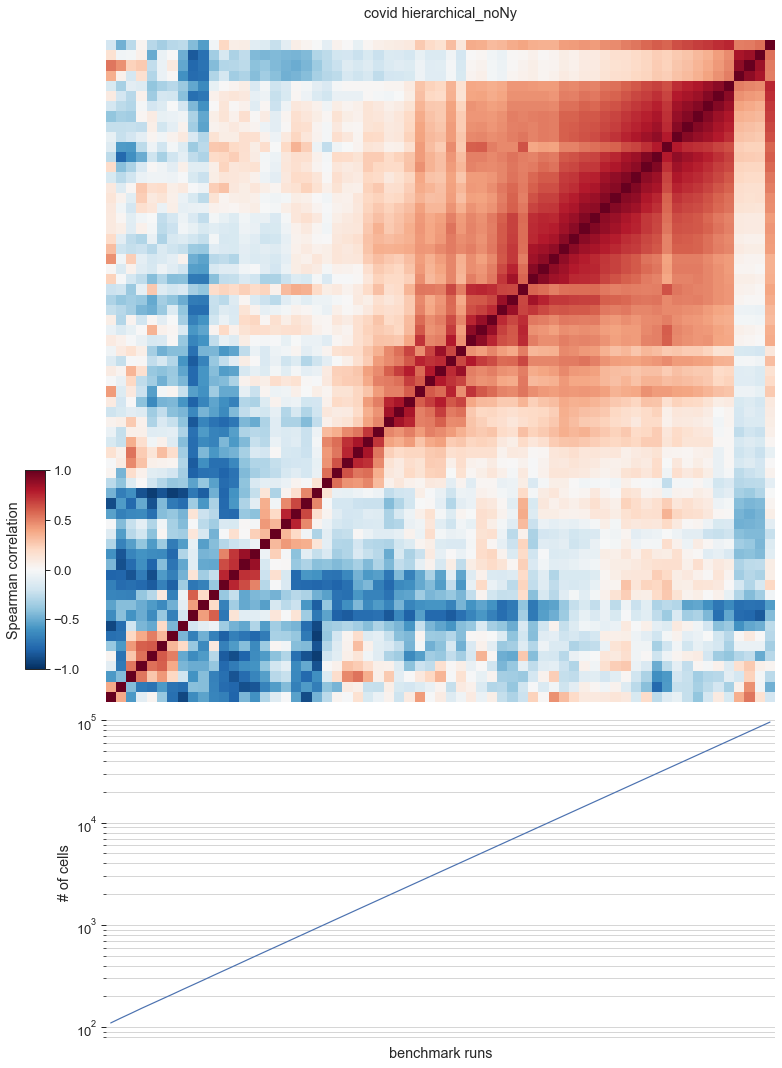

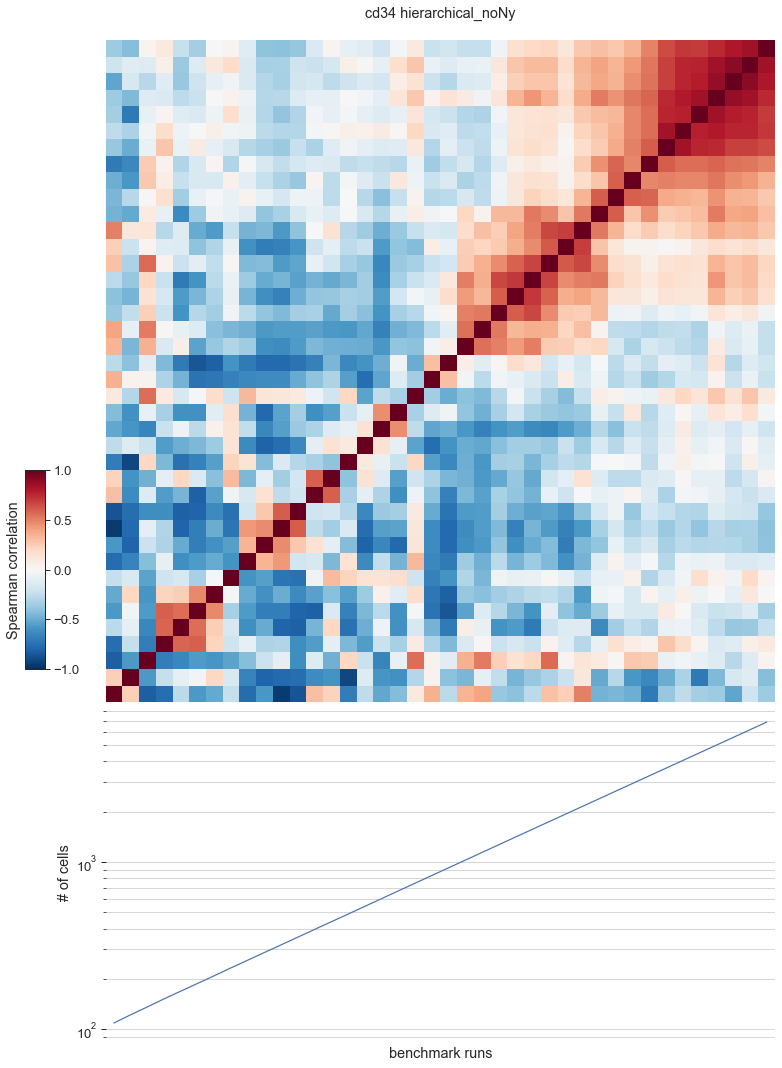

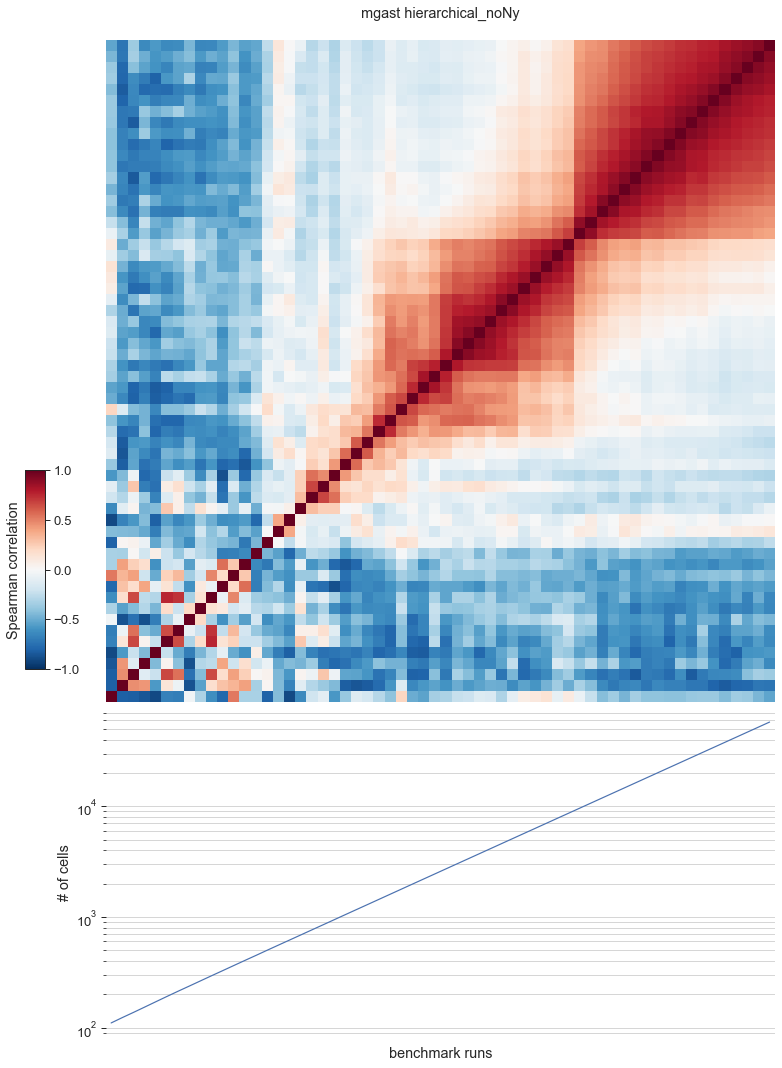

In [11]:
for key, cdf in corr_dict.items():
    if not key.endswith("hierarchical_noNy"):
        continue
    plot_correlations(ldcprr_dict[key], nticks=0)
    plt.show()

# Number of Diffusion Components

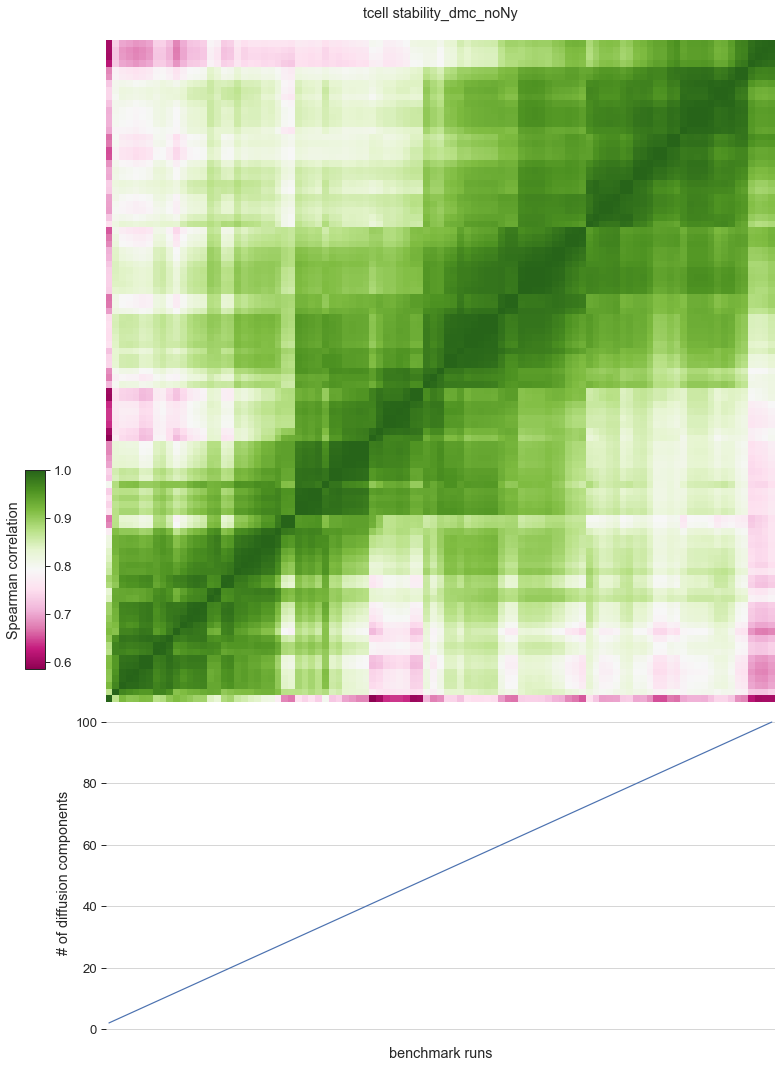

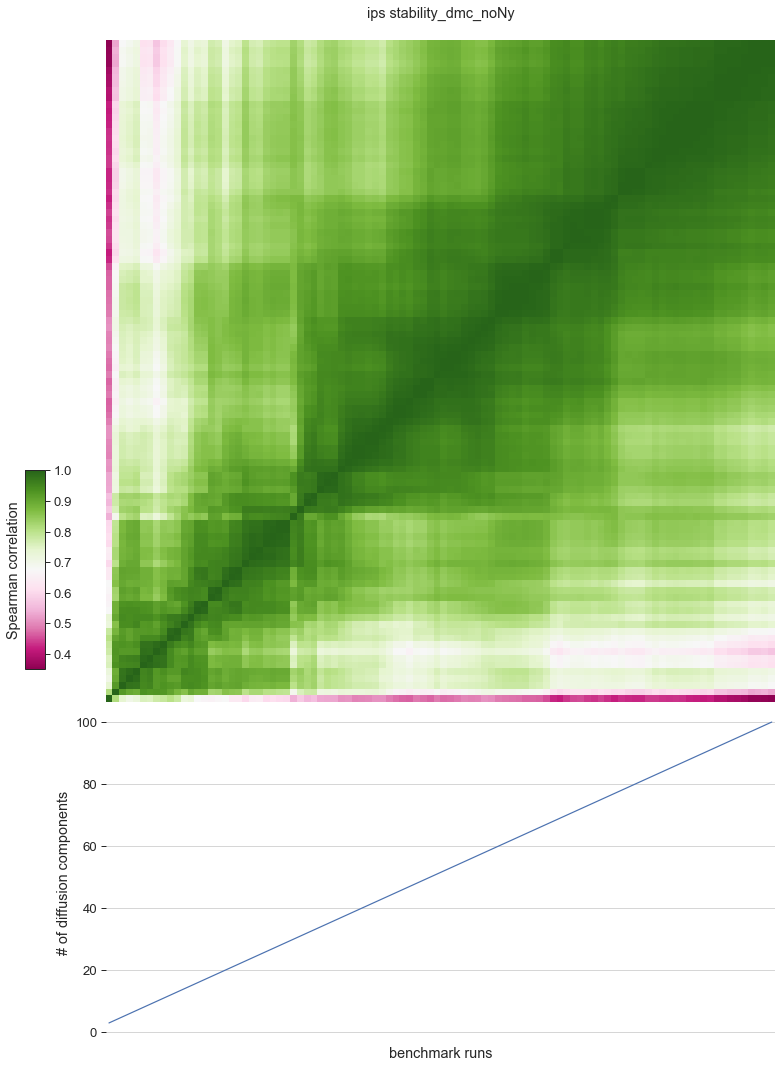

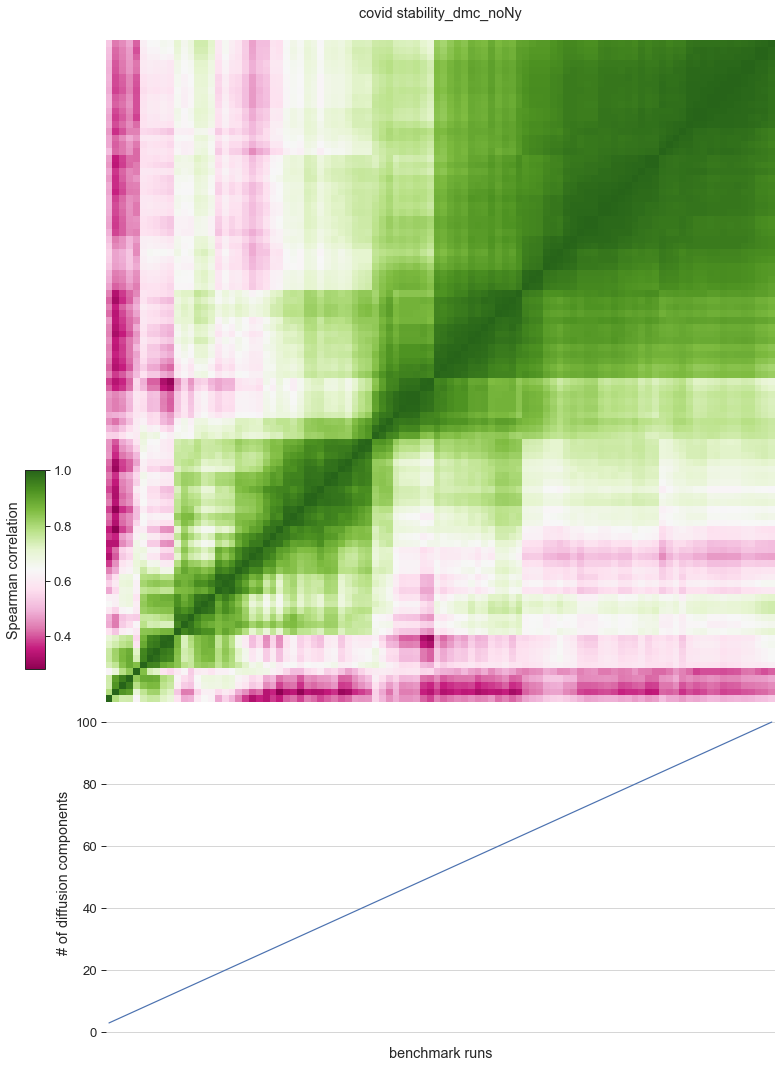

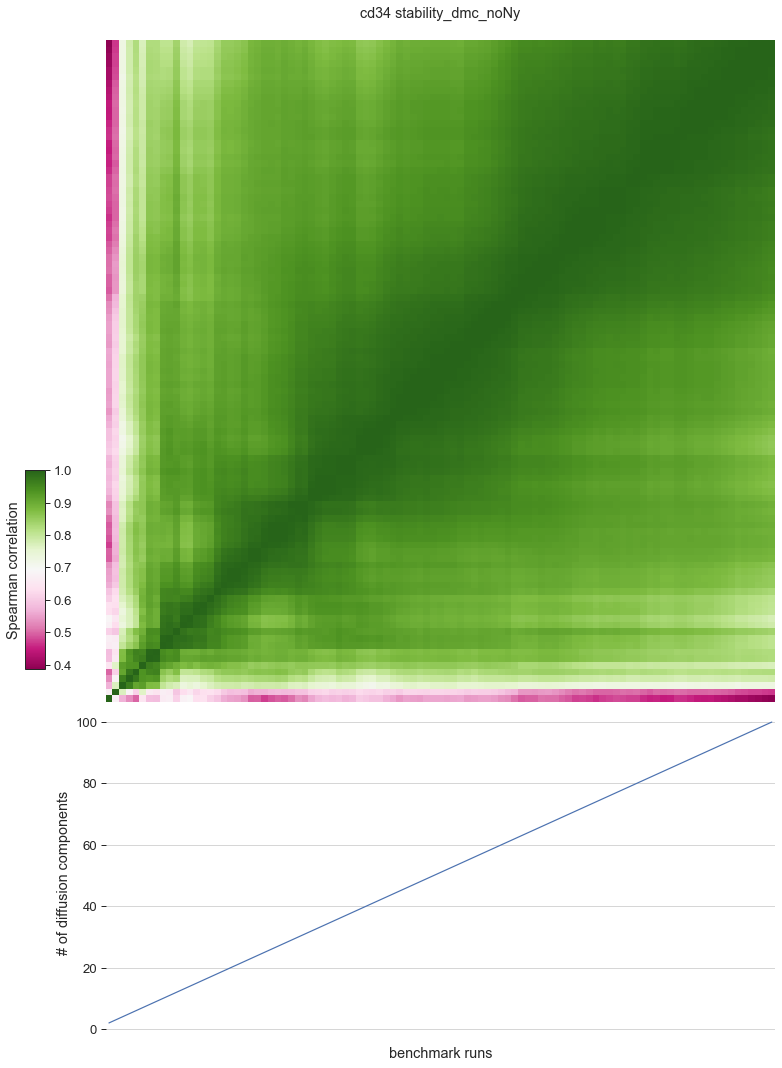

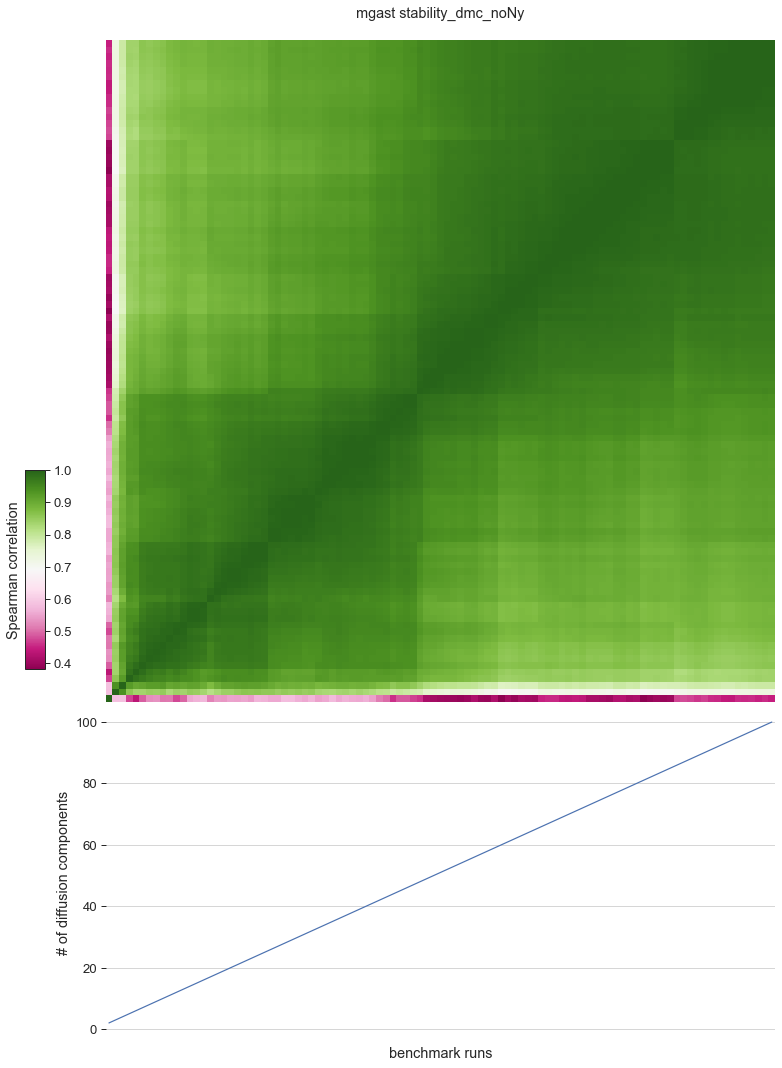

In [12]:
for key, cdf in corr_dict.items():
    if not key.endswith("dmc_noNy"):
        continue
    plot_correlations(corr_dict[key], clim=None, nticks=0, cmap="PiYG")
    plt.show()

# Parameter d

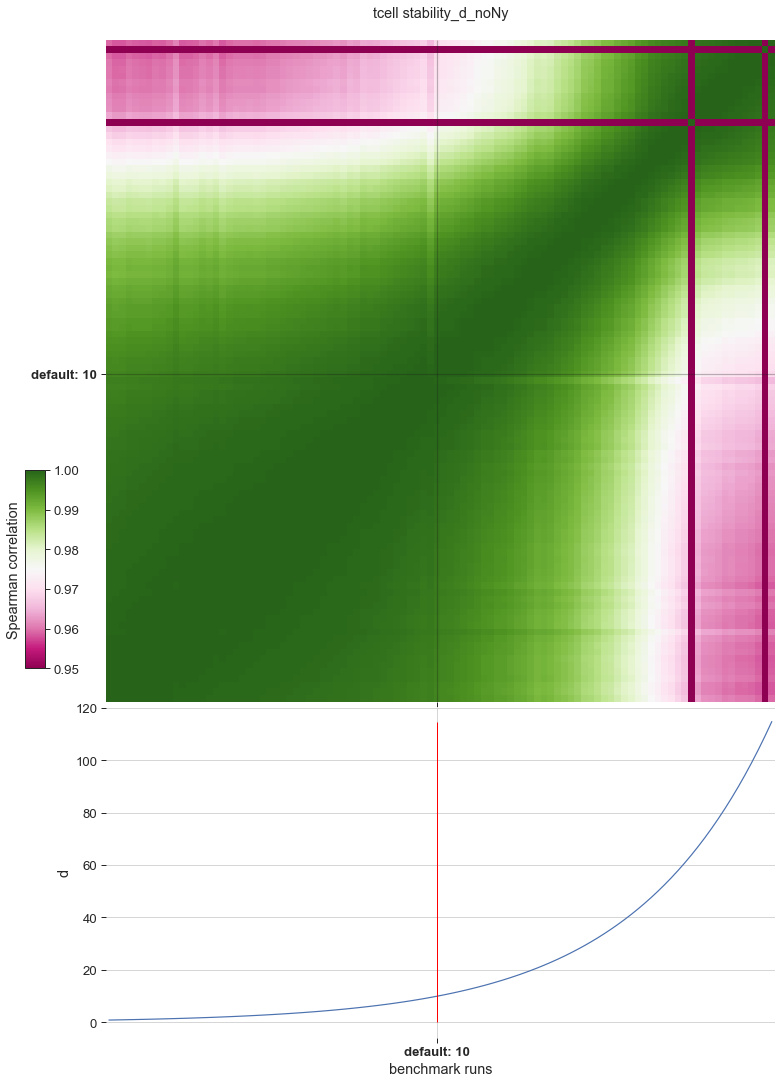

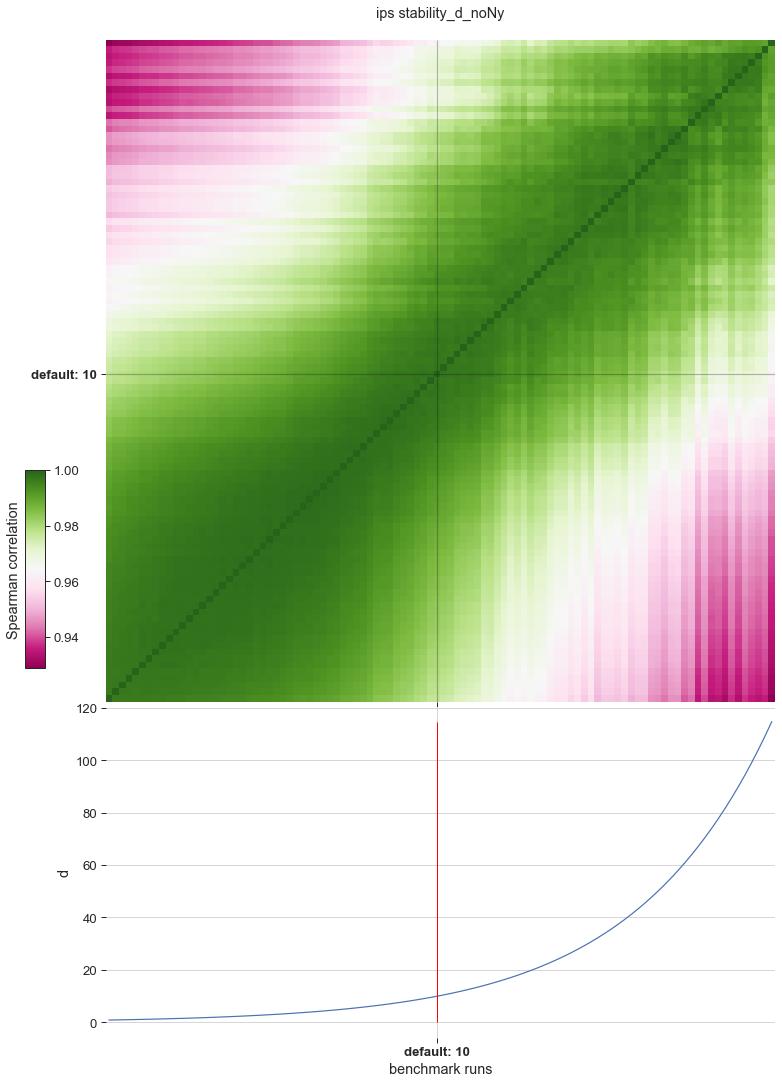

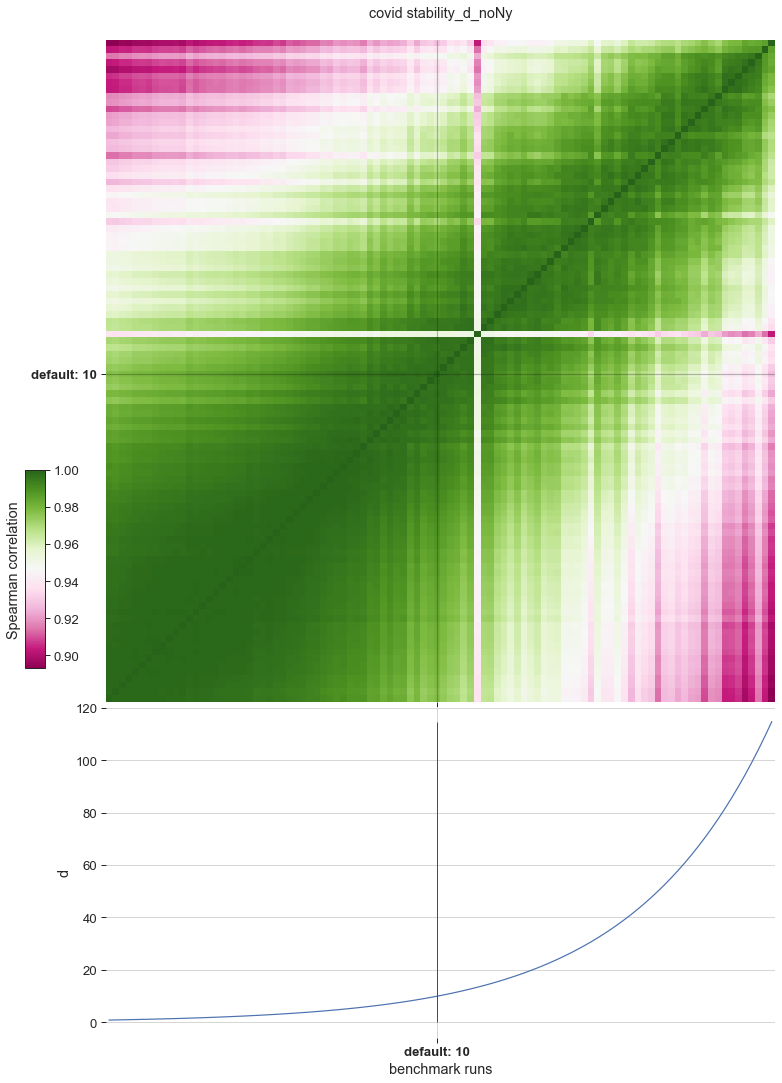

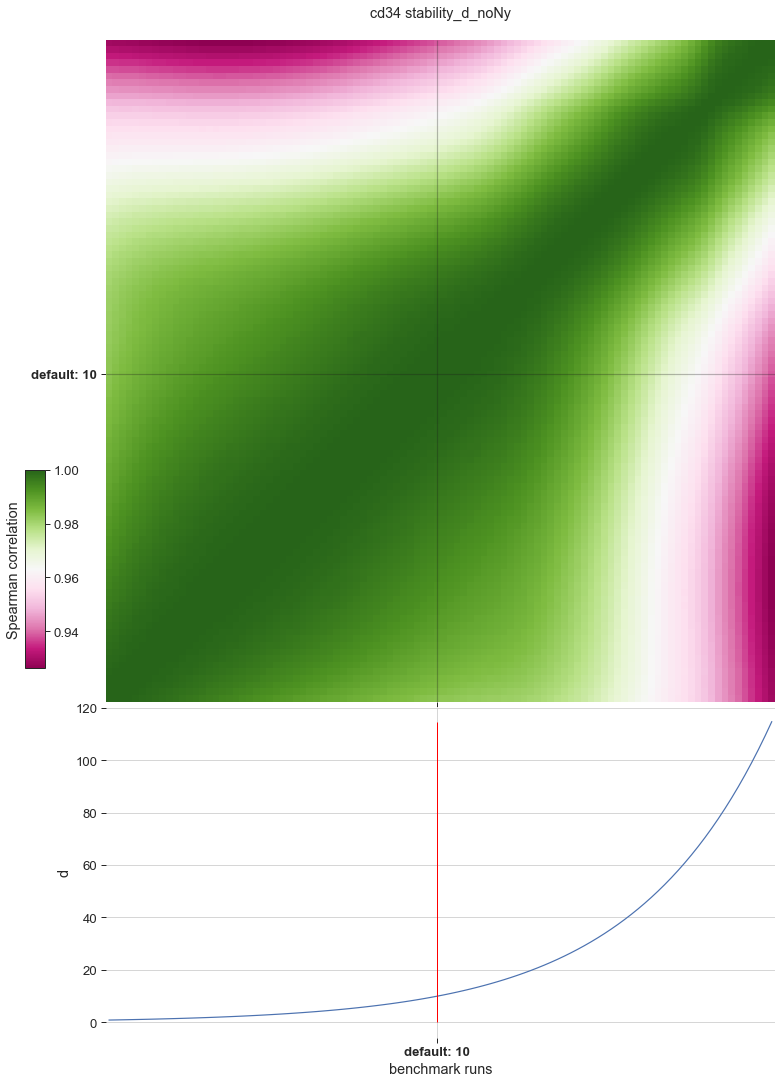

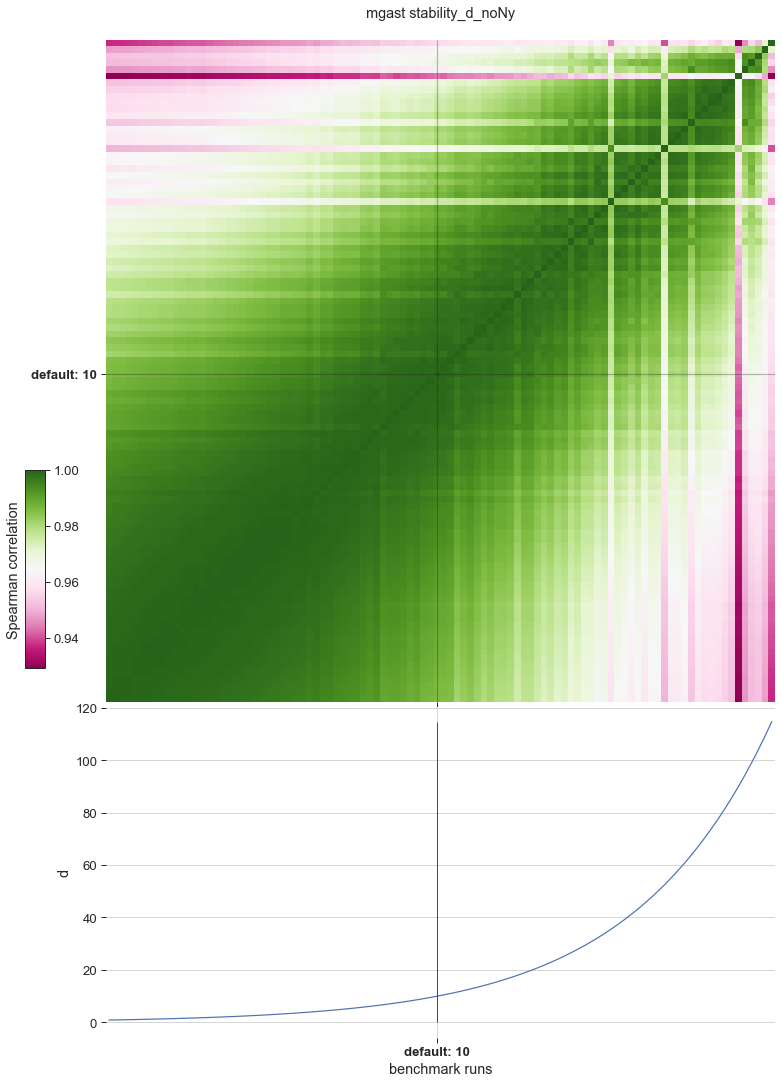

In [13]:
for key, cdf in corr_dict.items():
    if not key.endswith("_d_noNy"):
        continue
    clim = None
    if key.startswith("tcell"):
        clim = (.95, 1)
    plot_correlations(corr_dict[key], clim=clim, nticks=0, cmap="PiYG")
    plt.show()

# Number of Landmarks

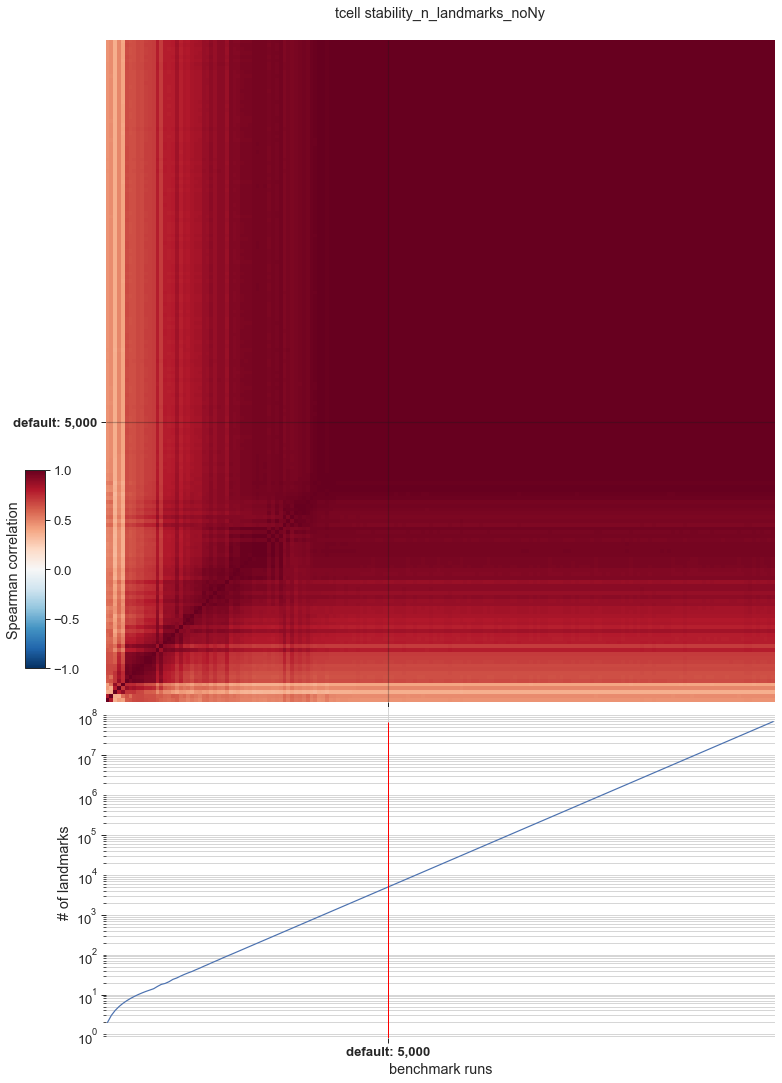

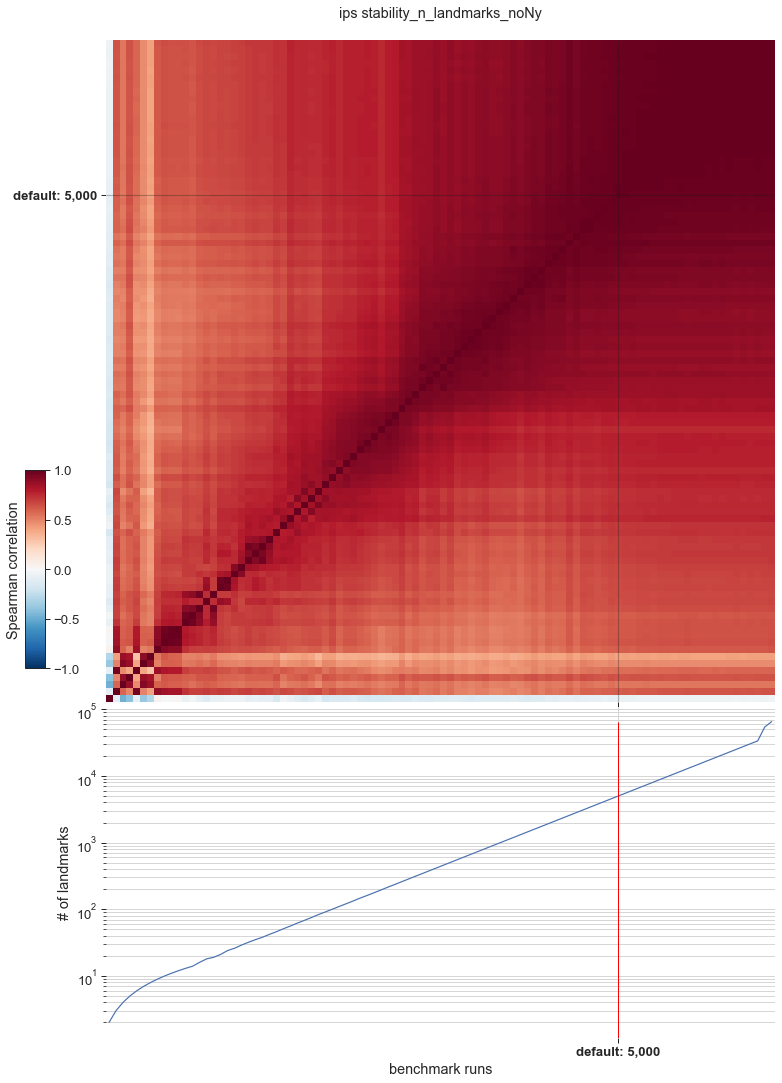

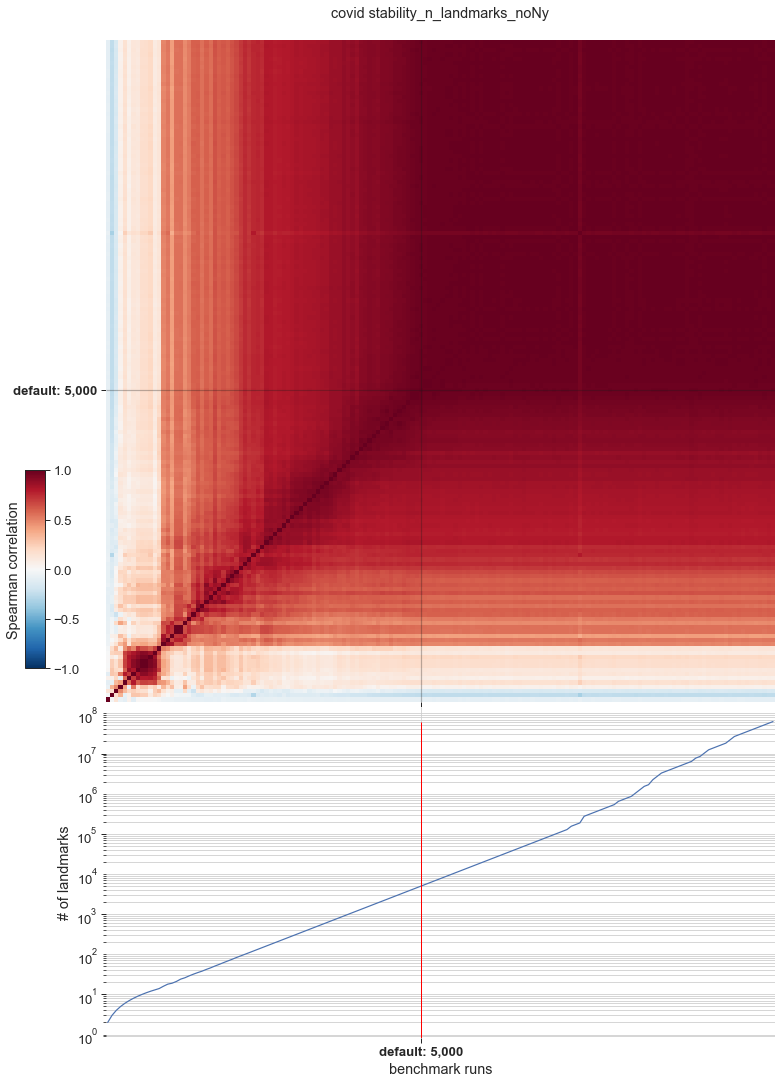

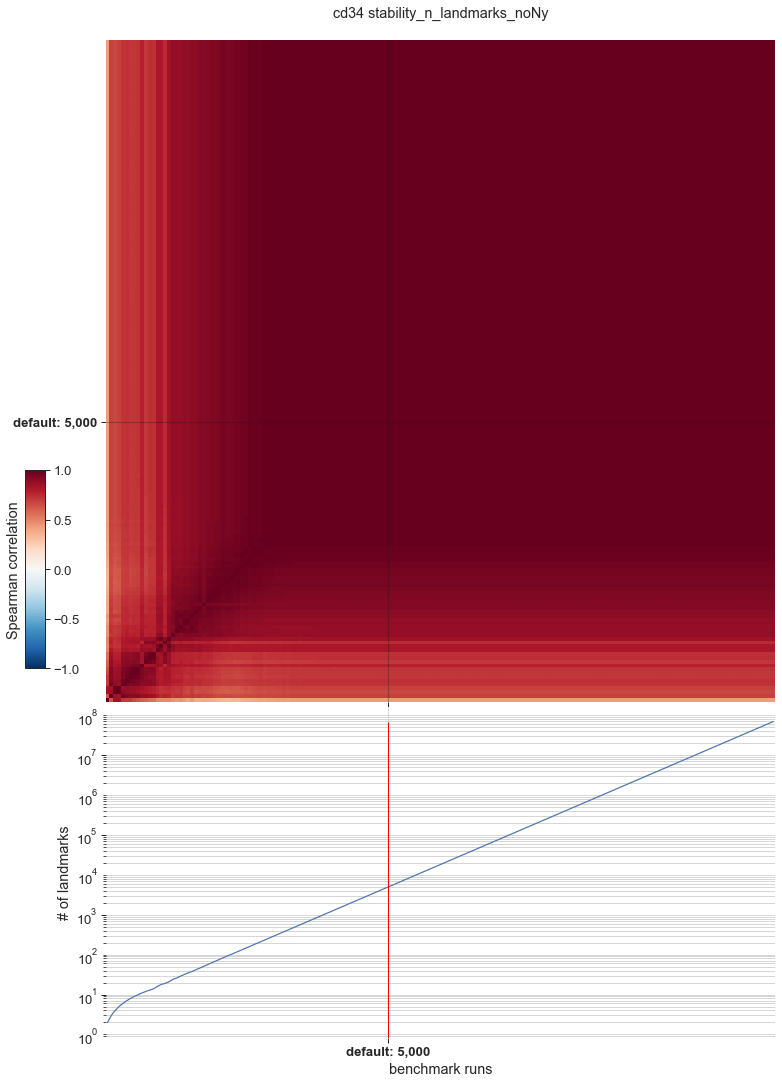

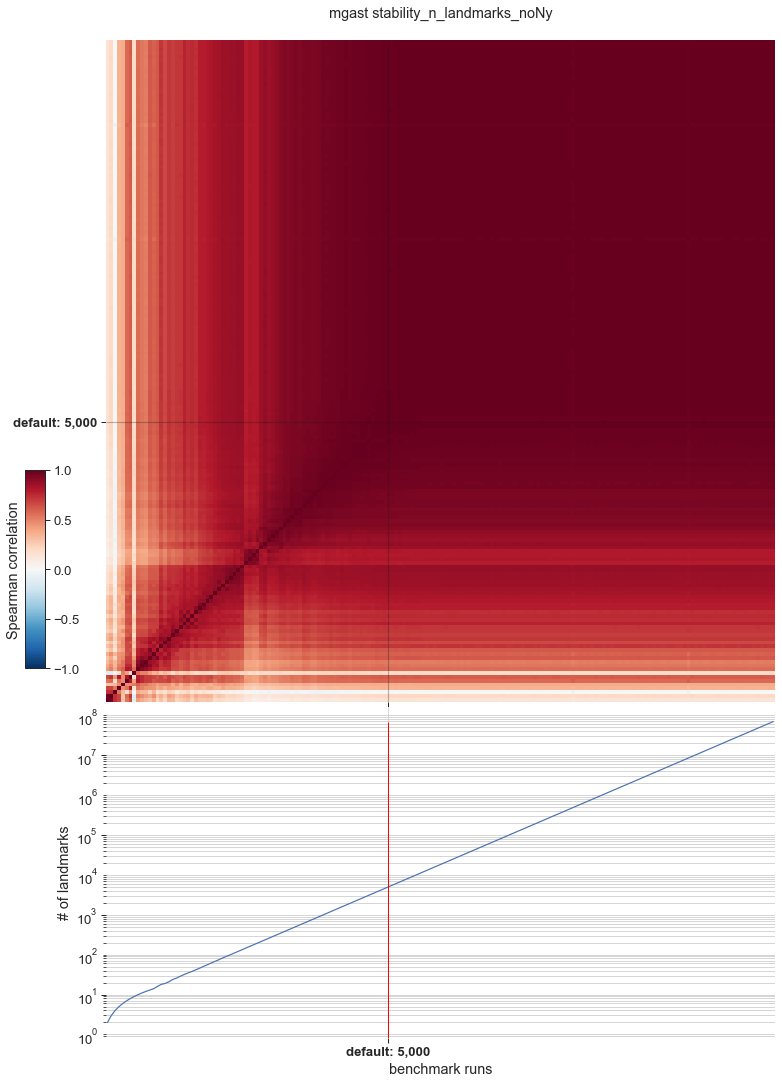

In [14]:
for key, cdf in corr_dict.items():
    if not key.endswith("n_landmarks_noNy"):
        continue
    plot_correlations(corr_dict[key])
    plt.show()

In [15]:
res_dfs = list()
for k, df in tqdm(results_dict.items()):
    if not k.endswith("n_landmarks_noNy"):
        continue
    stats = stats_dict[k]
    ds = stats["dataset"][0]
    test = stats["mode"][0]
    mname = aliases.get(test, test)
    stdic = stats_dict[f"{ds} stability_n_landmarks_noNy"]
    no_lands = stdic["n_landmarks"] == 0
    if any(no_lands):
        base_id = no_lands.idxmax()
    else:
        base_id = stdic["n_landmarks"].idxmax()
        n_land = stdic.loc[base_id, "n_landmarks"]
        print(f"Warning: {ds} uses {n_land:,} landmarks instead of landmark-less reference.")
    base = results_dict[f"{ds} stability_n_landmarks_noNy"].loc[:, base_id]
    corrs = df.corrwith(base)
    spcorrs = df.corrwith(base, method='spearman')
    rdf = pd.DataFrame({
        "dataset":ds,
        "test":test,
        "Clustering":mname,
        "n_landmarks":stats.loc[df.columns, "n_landmarks"],
        "Pearson correlation":corrs,
        "1 - Pearson correlation":1-corrs,
        "Spearman correlation":spcorrs,
        "1 - Spearman correlation":1-spcorrs,
    })
    res_dfs.append(rdf)
results = pd.concat(res_dfs)

  0%|          | 0/60 [00:00<?, ?it/s]

In [16]:
matplotlib.rcParams["axes.spines.bottom"] = "on"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "on"
matplotlib.rcParams["axes.spines.right"] = "off"

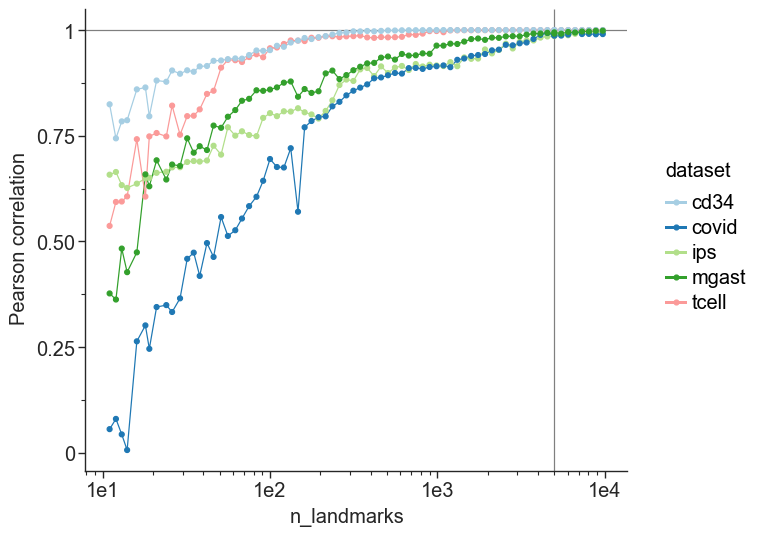

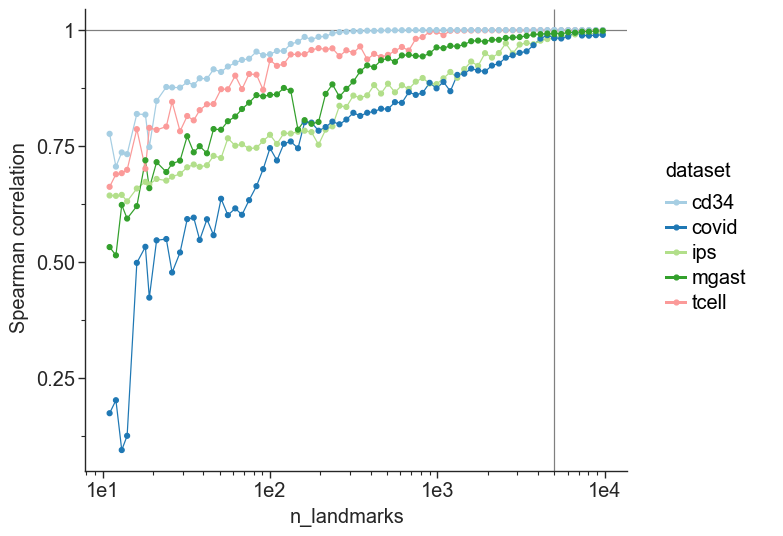

In [17]:
idx = (results["n_landmarks"] > 10) & (results["n_landmarks"] < 10000)
pdat = results.loc[idx, :]

pl = (
    p9.ggplot(pdat, p9.aes("n_landmarks", "Pearson correlation", color="dataset", group="dataset"))
    + p9.geom_hline(yintercept=1, alpha=.5)
    + p9.geom_vline(xintercept=5000, alpha=.5)
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10()
    + p9.scale_x_log10()
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.theme(figure_size=(7, 6))
)
print(pl)

idx = (results["n_landmarks"] > 10) & (results["n_landmarks"] < 10000)
pdat = results.loc[idx, :]

pl = (
    p9.ggplot(pdat, p9.aes("n_landmarks", "Spearman correlation", color="dataset", group="dataset"))
    + p9.geom_hline(yintercept=1, alpha=.5)
    + p9.geom_vline(xintercept=5000, alpha=.5)
    + p9.geom_line()
    + p9.geom_point()  # + p9.scale_y_log10()
    + p9.scale_x_log10()
    + p9.theme_matplotlib()
    + p9.scales.scale_color_brewer(type="qual", palette=3)
    + p9.theme(figure_size=(7, 6))
)
print(pl)

In [18]:
matplotlib.rcParams["axes.spines.bottom"] = "off"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "off"
matplotlib.rcParams["axes.spines.right"] = "off"

# Parameter Length Scale Factor

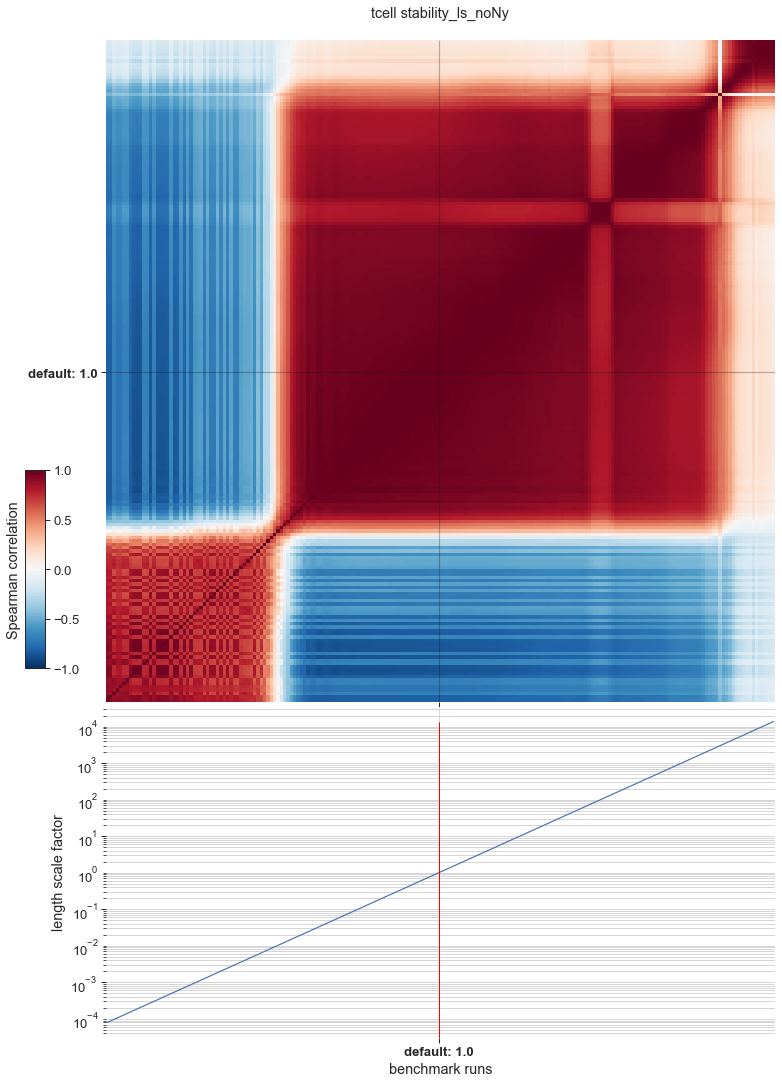

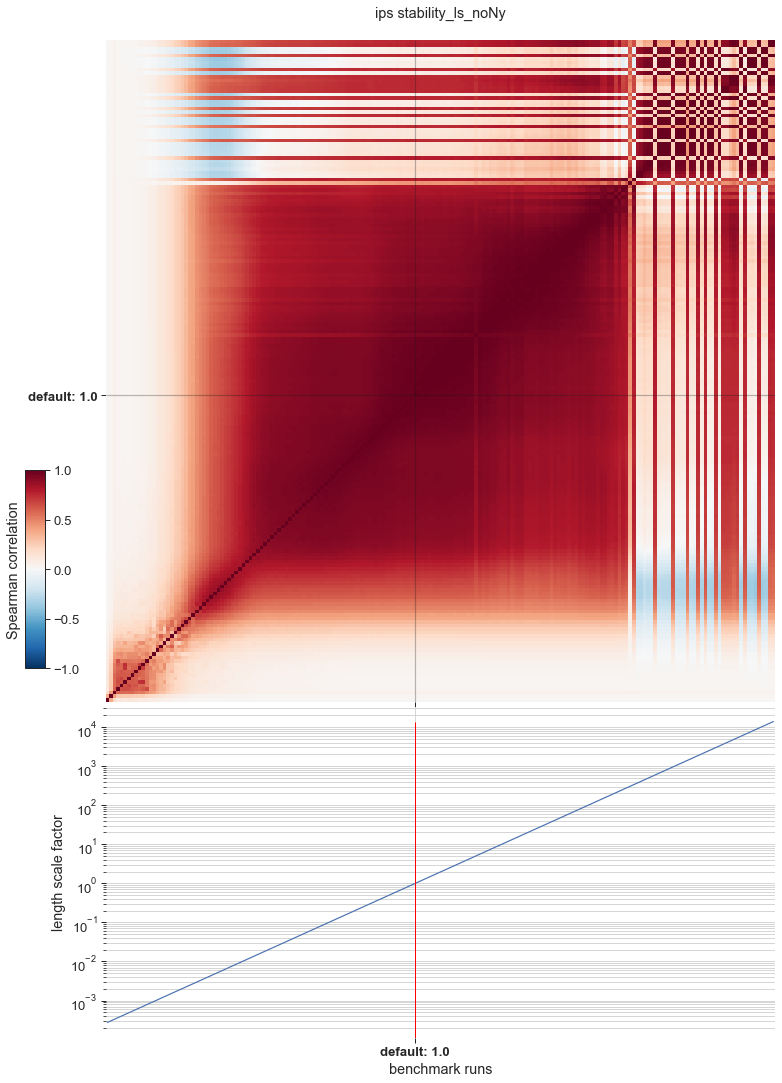

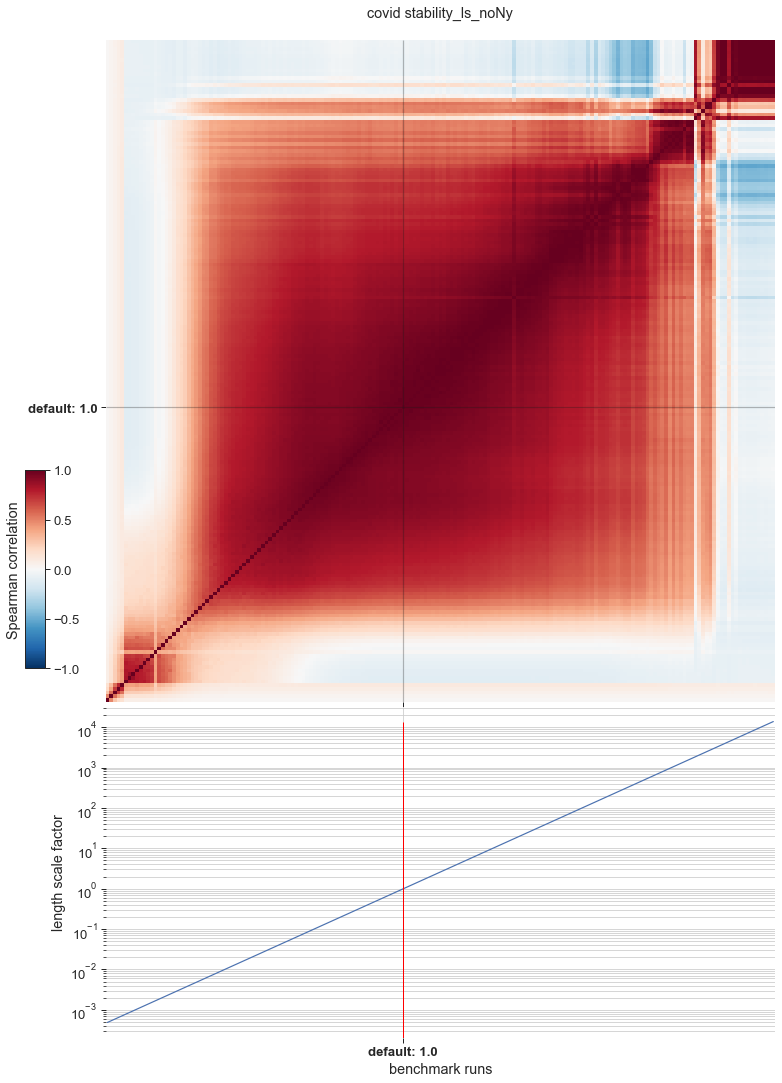

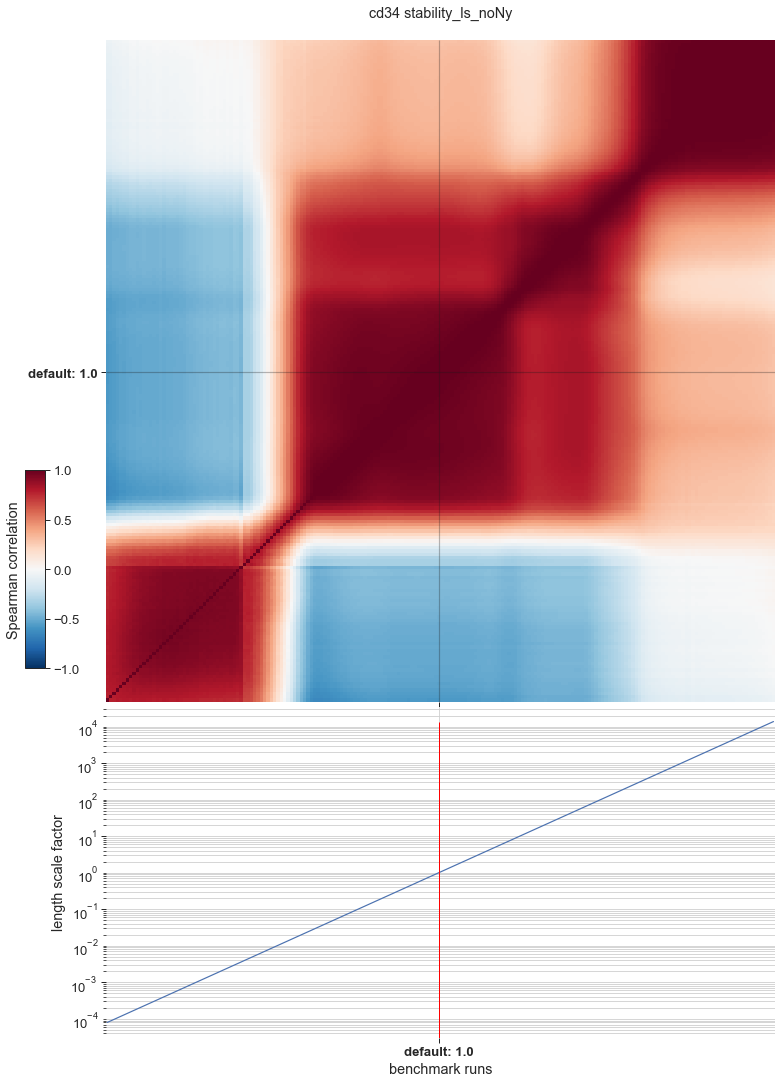

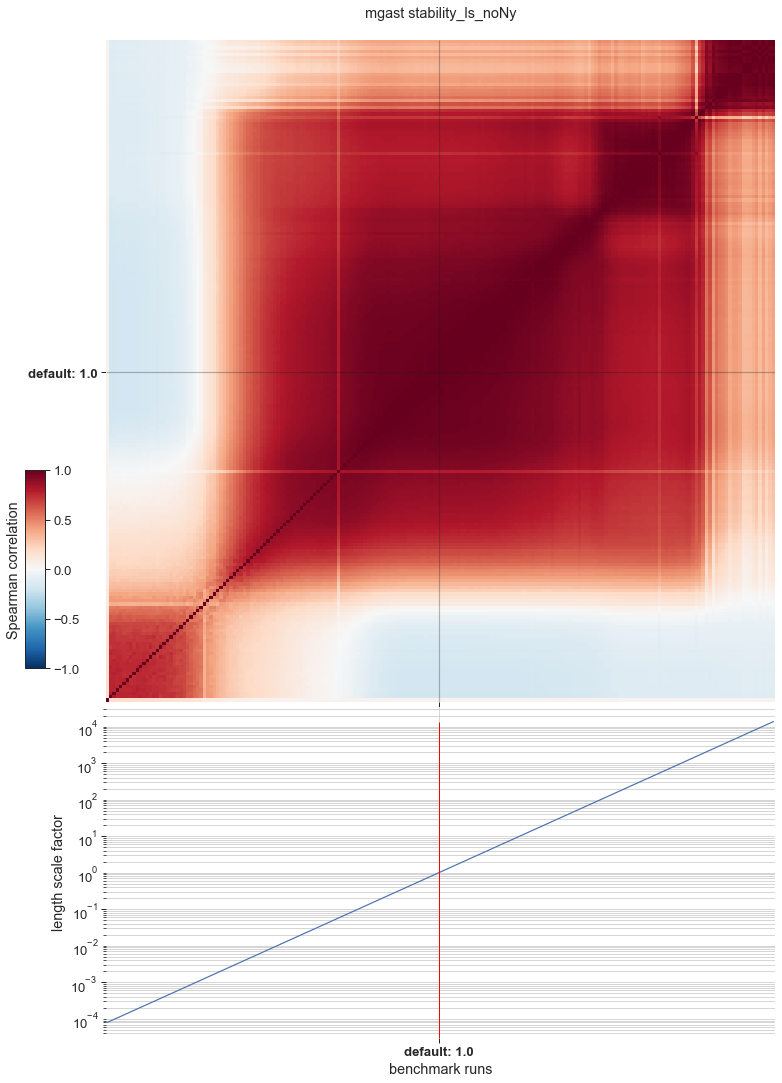

In [19]:
for key, cdf in corr_dict.items():
    if not key.endswith("ls_noNy"):
        continue
    plot_correlations(corr_dict[key])
    plt.show()

In [20]:
import pwd
user_info = pwd.getpwuid(os.getuid())
author = user_info.pw_gecos
email = user_info.pw_name + "@fredhutch.org"
%load_ext watermark
%watermark -a "{author}" -e {email} -h -v -iv -m -u -w -i

Author: Dominik Otto, S2-106, x4475,umask=0007, Setty Lab,

Email: dotto@fredhutch.org

Last updated: 2023-06-22T23:29:33.547378-07:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.5.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 4.15.0-192-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 36
Architecture: 64bit

Hostname: gizmok125

scipy     : 1.9.1
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21) 
[GCC 10.3.0]
pandas    : 1.4.4
mellon    : 1.0.2
plotnine  : 0.10.1.post4+g192928d
numpy     : 1.23.3
palantir  : 1.2
jax       : 0.3.17
matplotlib: 3.6.0
scanpy    : 1.9.1
re        : 2.2.1

Watermark: 2.3.1

